<a href="https://colab.research.google.com/github/prakharsingh97/Operations_Department/blob/main/Operations_Department.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#What are we going to learn 


1.   CNN 
2.   Deep Learning 
            1.  Pretrained Weights 
            2.  From Scratch 
3.   Resnet 
4.   Transfer Learning  -> Reduces Training Time
5.   Evalutaion 



# Case Study


#Importing Dataset


In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
#keras api calls tf and use to implement deep learning
from tensorflow.keras.applications.resnet50 import ResNet50
# Residual Network SOA pre- trained network
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#generate batches of images
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
#EarlyStopping prvents overfitting
#ModelCheckpoint select best model 
import matplotlib.pyplot as plt
import seaborn as sns
#data visualization
import pandas as pd


#Explore Dataset

In [2]:
#importing directory 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#getting the x-ray directory
X_ray_directory = '/content/drive/MyDrive/Projects/operation_deptt/Dataset'

In [4]:
#list folders now
os.listdir(X_ray_directory)

['3', '0', '2', '1']

In [5]:
#generate tensor image data using image generator and normalize them 
# use 20 per for cross validation 
#rescale = normalization 
image_generator = ImageDataGenerator(rescale = 1./255 , validation_split=  0.2)


In [6]:
#Generate batches of 40 images for training 
train_generator  = image_generator.flow_from_directory(batch_size= 40 ,directory= X_ray_directory , shuffle= True , target_size= (256,256), class_mode= 'categorical' , subset= 'training')

Found 428 images belonging to 4 classes.


In [7]:
#Validation 
valid_generator = image_generator.flow_from_directory(batch_size= 40 ,directory= X_ray_directory , shuffle= True , target_size= (256,256), class_mode= 'categorical' , subset= 'validation')

Found 104 images belonging to 4 classes.


In [8]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [9]:
train_images.shape

(40, 256, 256, 3)

In [10]:
train_labels.shape

(40, 4)

In [11]:
train_labels

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]],

In [12]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

#Data Visualization

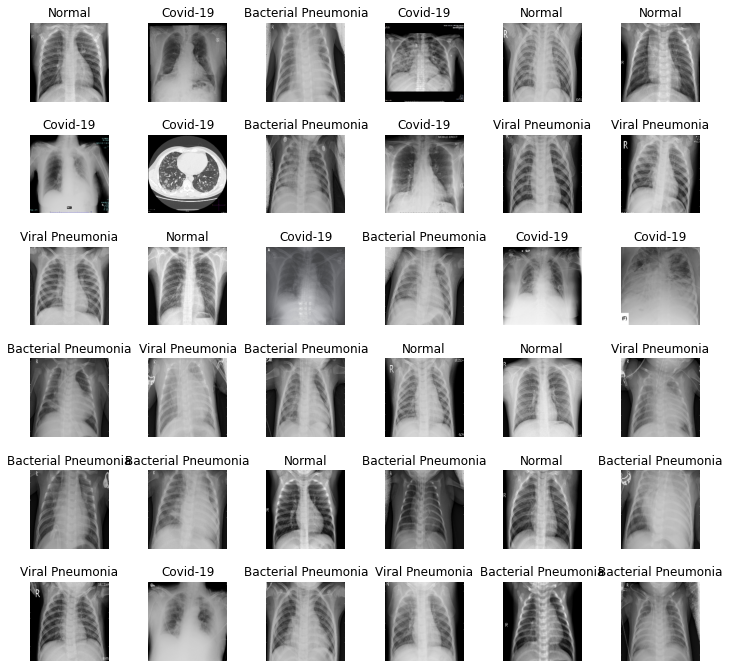

In [13]:
# Create a grid of 36 images along with their corresponding labels
#deep learning model has 
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)    

#Importing Model with Pre Trained Weights

In [14]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94773248/94765736 [==============================] - 1s 0us/step


In [15]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [17]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers[:-10]:
  layers.trainable = False

#Build a new model

In [18]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [19]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics= ["accuracy"])

In [22]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [24]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= X_ray_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= X_ray_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 10, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
107/107 [==============================] - 441s 4s/step - loss: 1.2862 - accuracy: 0.5131 - val_loss: 15.7944 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 15.79438, saving model to weights.hdf5
Epoch 2/10
107/107 [==============================] - 419s 4s/step - loss: 0.4945 - accuracy: 0.8164 - val_loss: 17.6026 - val_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 15.79438
Epoch 3/10
107/107 [==============================] - 420s 4s/step - loss: 0.3626 - accuracy: 0.9024 - val_loss: 41.7722 - val_accuracy: 0.2500

Epoch 00003: val_loss did not improve from 15.79438
Epoch 4/10
107/107 [==============================] - 429s 4s/step - loss: 0.2428 - accuracy: 0.9130 - val_loss: 16.2135 - val_accuracy: 0.2500

Epoch 00004: val_loss did not improve from 15.79438
Epoch 5/10
 27/107 [======>.......................] - ETA: 5:03 - loss: 0.2336 - accuracy: 0.8975